# SIFT
**SIFT (Scale-Invariant Feature Transform)** is a renowned algorithm in computer vision developed by David Lowe in 1999. Its primary aim is to detect and describe local features in images. These features are invariant to image scaling, rotation, and are robust across various changes like affine transformations, perspective shifts, noise, and illumination variations.

## Key Steps of SIFT:

1. **Scale-Space Extrema Detection**
    - Construct a scale space using the Gaussian function.
    - Identify potential keypoint locations using the Difference of Gaussians (DoG) in scale space.

2. **Keypoint Localization**
    - Refine the keypoints by eliminating low-contrast keypoints and those poorly localized on an edge.

3. **Orientation Assignment**
    - Assign a consistent orientation to keypoints based on local image gradient directions. This ensures invariance to rotation.

4. **Keypoint Descriptor Generation**
    - Describe the keypoints using a descriptor that captures gradient magnitude and orientation in its local neighborhood.

5. **Keypoint Matching**
    - Compare keypoints between images using a descriptor vector, typically employing a distance metric.

In [1]:
!pip install opencv-python opencv-contrib-python numpy matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


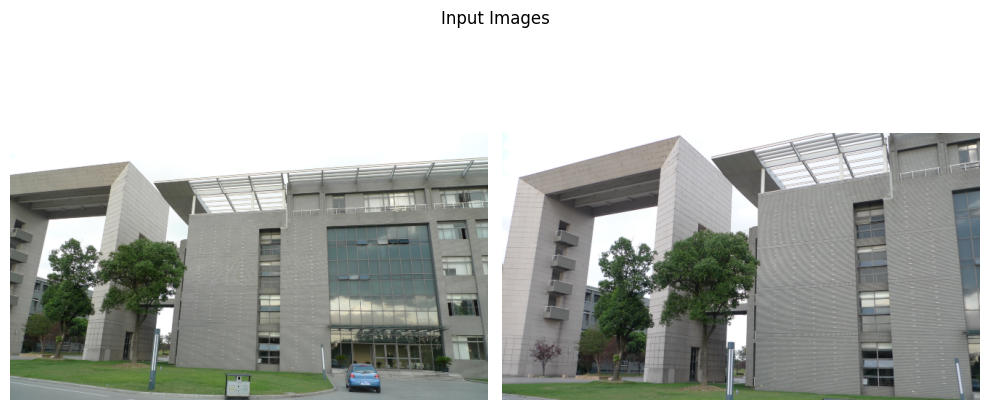

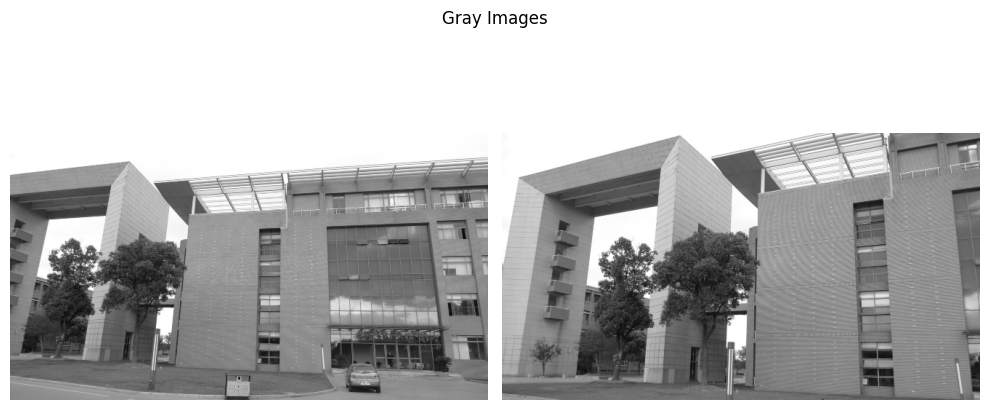

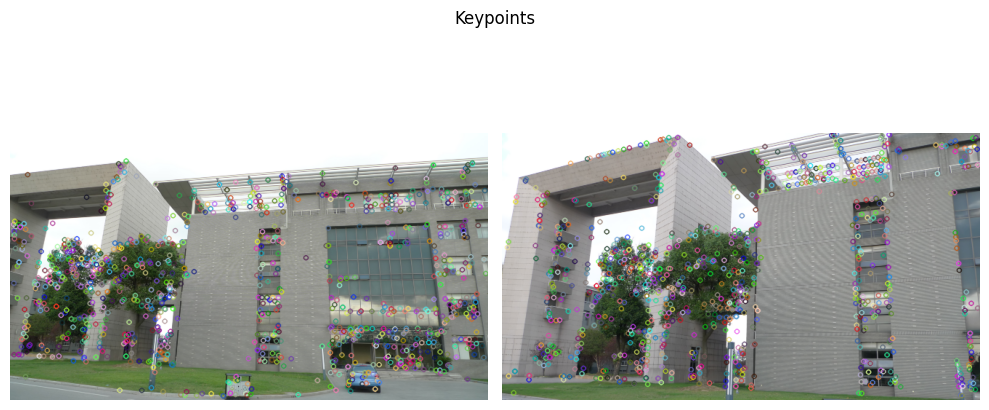

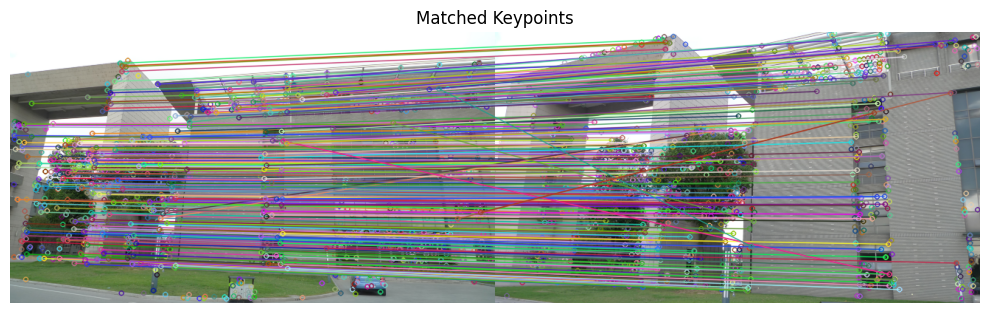

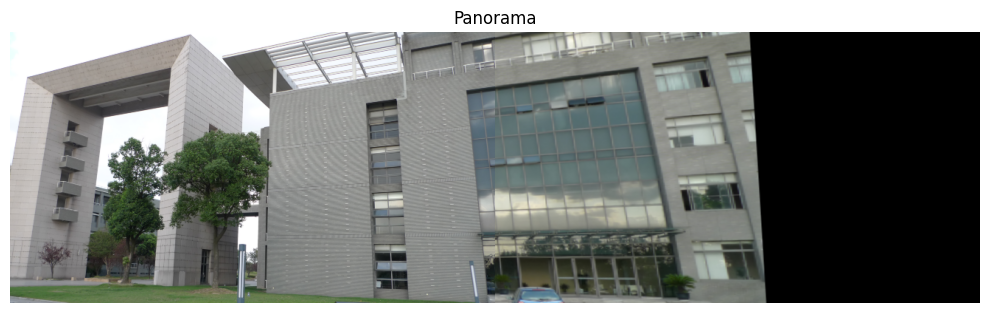

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(title, img):
    """
    Displays a single image using matplotlib.
    """
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_images(title, img1, img2):
    """
    Displays two images side by side using matplotlib.
    """
    plt.figure(figsize=(10,5))
    plt.suptitle(title)
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def stitch_images(img1_path, img2_path):
    """
    Stitches two images to create a panorama using SIFT features and FLANN-based matcher.
    """
    
    # Read the images from the given paths
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Display the input images side by side
    display_images("Input Images", img1, img2)

    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Display the grayscale images side by side
    display_images("Gray Images", gray1, gray2)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors for both images
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # Draw keypoints on the images
    img_kp1 = cv2.drawKeypoints(img1, kp1, None)
    img_kp2 = cv2.drawKeypoints(img2, kp2, None)

    # Display the images with keypoints side by side
    display_images("Keypoints", img_kp1, img_kp2)

    # Setup FLANN-based matcher with KDTREE algorithm
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Match descriptors using FLANN
    matches = flann.knnMatch(des1, des2, k=2)

    # Ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Draw the matches on the images
    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None)
    display_image("Matched Keypoints", matched_img)

    # Compute homography matrix using RANSAC
    points1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    points2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

    # Warp image1 using the computed homography
    h, w, _ = img2.shape
    panorama = cv2.warpPerspective(img1, H, (w*2, h))
    panorama[0:h, 0:w] = img2
    
    # Display the final stitched panorama
    display_image("Panorama", panorama)
    
    return panorama

# Example usage
img_path1 = "sse2.bmp"
img_path2 = "sse1.bmp"
panorama = stitch_images(img_path1, img_path2)
